In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from pytorch_forecasting import TemporalFusionTransformer

# custom functions
from utils import config_load, round_unix, signal_map, create_dataset, color_print

/home/sam/anaconda3/envs/trading/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data
### Market Data in TBBO Schema (https://databento.com/datasets/XNAS.ITCH)
I used the Nasdaq TotalView-ITCH data from Databento. 
The data is in the TBBO (Trade with Best Bid & Offer) schema.
*"TBBO provides individual trade events combined with the best bid and offer (BBO) immediately preceding each trade. 
It differs from MBP-1, as TBBO includes non-trade events that modify the book depth at the BBO (https://databento.com/blog/market-data-schemas)."*
The data is in the form of a CSV file. The data contains the following columns:

Independent Variables:

    ts_recv
        The capture-server-received timestamp expressed as the number of nanoseconds since the UNIX epoch.
    ts_event
        The matching-engine-received timestamp expressed as the number of nanoseconds since the UNIX epoch.
    rtype
        The record type. Each schema corresponds with a single rtype value.
    publisher_id
        The publisher ID assigned by Databento, which denotes dataset and venue.
    instrument_id
        The numeric instrument ID.
    action
        The event action. Will always be [T]rade in the TBBO schema.
    side
        The side that initiates the event. Can be [A]sk for a sell aggressor, [B]id for a buy aggressor, or [N]one where no side is specified by the original trade.
    depth
        The book level where the update event occurred.
    price
        The order price expressed as a signed integer where every 1 unit corresponds to 1e-9, i.e. 1/1,000,000,000 or 0.000000001.
    size
        The order quantity.
    flags
        A bit field indicating event end, message characteristics, and data quality.
    ts_in_delta
        The matching-engine-sending timestamp expressed as the number of nanoseconds before ts_recv.
    sequence
        The message sequence number assigned at the venue.
    bid_px_00
        The bid price at the top level.
    ask_px_00
        The ask price at the top level.
    bid_sz_00
        The bid size at the top level.
    ask_sz_00
        The ask size at the top level.
    bid_ct_00
        The number of bid orders at the top level.
    ask_ct_00
        The number of ask orders at the top level.
    symbol
        The requested symbol for the instrument.

In [2]:
# load data
fname = "xnas-itch-20230703.tbbo.csv"
df = pd.read_csv(fname)
df.head()

,ts_recv,ts_event,rtype,publisher_id,instrument_id,action,side,depth,price,size,flags,ts_in_delta,sequence,bid_px_00,ask_px_00,bid_sz_00,ask_sz_00,bid_ct_00,ask_ct_00,symbol
0,1688371200660869841,1688371200660704717,1,2,32,T,B,0,194120000000,1,130,165124,303634,193630000000,194120000000,27,27,1,1,AAPL
1,1688371201201402566,1688371201201237816,1,2,32,T,B,0,194110000000,2,130,164750,304724,193900000000,194110000000,5,400,1,1,AAPL
2,1688371201233688992,1688371201233524761,1,2,32,T,B,0,194110000000,8,130,164231,304850,193900000000,194110000000,5,398,1,1,AAPL
3,1688371201317556361,1688371201317392163,1,2,32,T,B,0,194110000000,2,130,164198,305101,193900000000,194110000000,5,390,1,1,AAPL
4,1688371201478520666,1688371201478356044,1,2,32,T,B,0,194000000000,7,130,164622,306430,193900000000,194000000000,5,200,1,1,AAPL


In [3]:
# data stastistics
df.describe()

,ts_recv,ts_event,rtype,publisher_id,instrument_id,depth,price,size,flags,ts_in_delta,sequence,bid_px_00,ask_px_00,bid_sz_00,ask_sz_00,bid_ct_00,ask_ct_00
count,5.927100e+04,5.927100e+04,59271.0,59271.0,59271.0,59271.0,5.927100e+04,5.927100e+04,59271.000000,59271.000000,5.927100e+04,5.927100e+04,5.927100e+04,59271.000000,59271.000000,59271.000000,59271.000000
mean,1.688395e+18,1.688395e+18,1.0,2.0,32.0,0.0,1.927011e+11,1.394686e+02,61.235815,172156.632822,1.172459e+08,1.926946e+11,1.927101e+11,738.695483,741.379359,10.615849,5.099475
std,5.694685e+12,5.694685e+12,0.0,0.0,0.0,0.0,5.627556e+08,1.039909e+04,64.699284,26884.568927,7.488858e+07,5.602114e+08,5.664950e+08,1599.085114,1410.068586,41.641281,4.956530
min,1.688371e+18,1.688371e+18,1.0,2.0,32.0,0.0,1.917700e+11,1.000000e+00,0.000000,163801.000000,3.036340e+05,1.917600e+11,1.917700e+11,1.000000,1.000000,1.000000,1.000000
25%,1.688392e+18,1.688392e+18,1.0,2.0,32.0,0.0,1.922150e+11,1.000000e+01,0.000000,165346.000000,4.842746e+07,1.922100e+11,1.922200e+11,110.000000,181.000000,2.000000,2.000000
50%,1.688395e+18,1.688395e+18,1.0,2.0,32.0,0.0,1.925200e+11,6.100000e+01,0.000000,167297.000000,1.170598e+08,1.925100e+11,1.925300e+11,361.000000,438.000000,4.000000,4.000000
75%,1.688399e+18,1.688399e+18,1.0,2.0,32.0,0.0,1.930900e+11,1.000000e+02,130.000000,170600.000000,1.774514e+08,1.930800e+11,1.930900e+11,800.000000,894.000000,8.000000,7.000000
max,1.688418e+18,1.688418e+18,1.0,2.0,32.0,0.0,1.942900e+11,2.377299e+06,130.000000,918606.000000,2.525346e+08,1.942400e+11,1.943000e+11,22157.000000,34742.000000,575.000000,94.000000


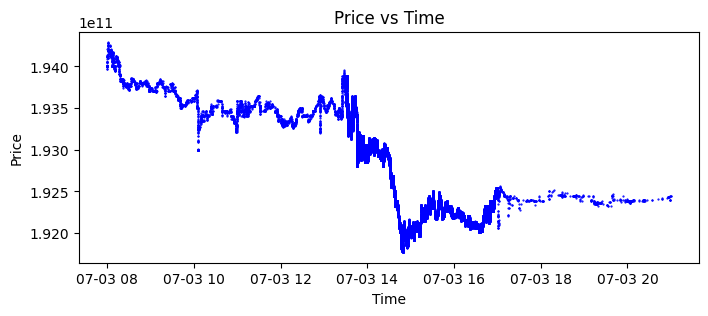

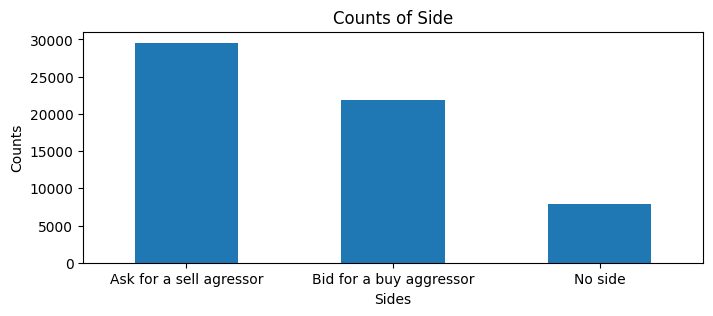

In [4]:
# let's take a look into the data
def unix_to_date(ts):
    return pd.to_datetime(ts, unit='ns')

# Price vs. Time
plt.figure(figsize=(8, 3))
plt.scatter(df.ts_event.apply(unix_to_date), df.price, s=0.3, c='blue')
plt.title("Price vs Time")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

# Counts of Side
plt.figure(figsize=(8, 3))
df.side.value_counts().plot(kind='bar')
plt.title("Counts of Side")
plt.xlabel("Sides")
plt.ylabel("Counts")
plt.xticks(rotation=0)
plt.xticks(range(3), ['Ask for a sell agressor', 'Bid for a buy aggressor', 'No side'])
plt.show()

## Data Preprocessing
The dataset is raw and we need to prepreocess it appropriately before we can use it for training a model.

The following steps are performed to preprocess the data:
1. Load the data
2. Round the Unix Timestamps (in nano second) to the nearest second.
3. Map the side (a.k.a. aggressor in trade) values (Ask, Bid, or None) to corresponding trading signals (0, 1, or 2) which represents (Buy, Sell, or None). This is a naive approach and can be improved with extra techniques enhanced with domain knowledge. With this processed signal, create a new variable "signal" which is the target variable. Drop the original "side" variable.
4. Drop unncessary variables such as "ts_event" as ts_recv is sufficient for representing the time of the event.
5. Replace any NaN values with 0.

In [5]:
# round the unix timestamp to seconds
df['ts_recv'] = df['ts_recv'].apply(round_unix)

# map 'side' to 'signal' (0 for Buy, 1 for Sell, 2 for Hold) and add it as a new column
df['signal'] = df['side'].apply(signal_map)

# drop side column
df.drop(columns='side', inplace=True)

# drop ts_event column
df.drop(columns='ts_event', inplace=True)

# replace NaN with 0
df.fillna(0, inplace=True)

df.head()

,ts_recv,rtype,publisher_id,instrument_id,action,depth,price,size,flags,ts_in_delta,sequence,bid_px_00,ask_px_00,bid_sz_00,ask_sz_00,bid_ct_00,ask_ct_00,symbol,signal
0,1688371200,1,2,32,T,0,194120000000,1,130,165124,303634,193630000000,194120000000,27,27,1,1,AAPL,1
1,1688371201,1,2,32,T,0,194110000000,2,130,164750,304724,193900000000,194110000000,5,400,1,1,AAPL,1
2,1688371201,1,2,32,T,0,194110000000,8,130,164231,304850,193900000000,194110000000,5,398,1,1,AAPL,1
3,1688371201,1,2,32,T,0,194110000000,2,130,164198,305101,193900000000,194110000000,5,390,1,1,AAPL,1
4,1688371201,1,2,32,T,0,194000000000,7,130,164622,306430,193900000000,194000000000,5,200,1,1,AAPL,1


In [6]:
# There are also static variables in our dataset
single_value_vars = []
for col in df.columns:
    if len(df[col].unique()) == 1:
        single_value_vars.append(col)
print("Single value variables:", single_value_vars)

Single value variables: ['rtype', 'publisher_id', 'instrument_id', 'action', 'depth', 'symbol']


## Training
I created a Temporal Fusion Transformer (TFT) model (https://arxiv.org/abs/1912.09363; B Lim, 2019) using Pytorch Forecasting library.
Pytorch Forecasting libary is based on Pytorch Lightning and provides a high-level interface for time series forecasting.

The model can take time-series data of various features and predict the target variable. The model is based on the Temporal Fusion Transformer (TFT) architecture which is a transformer-based model that can handle time-series data with static and dynamic features as well as categorical and continuous (numerical) variables.

I grouped my preprocessed data accordingly to appropriately categorize the features. The time-series data that I created for the model training takes the following features:
- max_encoder_length: 50,  # number of historical time steps to use for making predictions
- max_prediction_length: 10,  # number of future time steps the model is expected to predict
- time_idx: "ts_recv", # timestamp
- target: target_var, # target variable
- group_ids: "instrument_id" # IDs of groups within time-series data
- static_categoricals: ['action', 'symbol'], # categorical single-value variables
- static_reals: ['rtype', 'publisher_id', 'instrument_id', 'depth'], # static real (numerical) variables
- time_varying_known_reals: ['ts_recv', 'price', 'size', 'flags', 'ts_in_delta', 'sequence', 'bid_px_00', 'ask_px_00', 'bid_sz_00', 'ask_sz_00', 'bid_ct_00', 'ask_ct_00'], # Dynamic real (numerical) variables
- time_varying_unknown_reals: None since we do not have any unknown dynamic variables.


In [7]:
# configurations
config = config_load("config.yml")
for key, value in config.items():
    print(f"{key}: {value}")

path: {'data': 'xnas-itch-20230703.tbbo.csv', 'checkpoint': 'checkpoints'}
model: {'device': 'cuda', 'hidden_size': 8, 'hidden_continuous_size': 8, 'attention_head_size': 4, 'max_encoder_length': 50, 'max_prediction_length': 10}
train: {'num_workers': 2, 'batch': 32, 'epochs': 5, 'optimizer': 'AdamW', 'lr': 0.002, 'dropout': 0.3, 'patience': 3}


In [10]:
# train the model
os.system("python train.py")

path: {'data': 'xnas-itch-20230703.tbbo.csv', 'checkpoint': 'checkpoints'}
model: {'device': 'cuda', 'hidden_size': 8, 'hidden_continuous_size': 8, 'attention_head_size': 4, 'max_encoder_length': 50, 'max_prediction_length': 10}
train: {'num_workers': 2, 'batch': 32, 'epochs': 5, 'optimizer': 'AdamW', 'lr': 0.002, 'dropout': 0.3, 'patience': 3}
Data loaded and processed.
Dataset created.
Dataloaders created.
Loss Function: QuantileLoss
Optimizer: AdamW
Number of parameters in network: 15.3k
Model: TemporalFusionTransformer
Training started...


/home/sam/anaconda3/envs/trading/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/sam/anaconda3/envs/trading/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/sam/anaconda3/envs/trading/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the 

Epoch 0: 100%|██████████| 1190/1190 [02:58<00:00,  6.69it/s, v_num=23, train_loss_step=0.219]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 1190/1190 [03:44<00:00,  5.30it/s, v_num=23, train_loss_step=0.219, val_loss=0.180, train_loss_epoch=0.221]

Metric val_loss improved. New best score: 0.180


Epoch 1: 100%|██████████| 1190/1190 [03:06<00:00,  6.38it/s, v_num=23, train_loss_step=0.184, val_loss=0.180, train_loss_epoch=0.221]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1190/1190 [03:55<00:00,  5.06it/s, v_num=23, train_loss_step=0.184, val_loss=0.166, train_loss_epoch=0.177]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.166


Epoch 2: 100%|██████████| 1190/1190 [03:11<00:00,  6.20it/s, v_num=23, train_loss_step=0.156, val_loss=0.166, train_loss_epoch=0.177]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1190/1190 [04:02<00:00,  4.91it/s, v_num=23, train_loss_step=0.156, val_loss=0.158, train_loss_epoch=0.168]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.158


Epoch 3: 100%|██████████| 1190/1190 [03:12<00:00,  6.17it/s, v_num=23, train_loss_step=0.144, val_loss=0.158, train_loss_epoch=0.168]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1190/1190 [04:04<00:00,  4.88it/s, v_num=23, train_loss_step=0.144, val_loss=0.153, train_loss_epoch=0.161]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.153


Epoch 4: 100%|██████████| 1190/1190 [03:12<00:00,  6.18it/s, v_num=23, train_loss_step=0.132, val_loss=0.153, train_loss_epoch=0.161]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 1190/1190 [04:04<00:00,  4.87it/s, v_num=23, train_loss_step=0.132, val_loss=0.146, train_loss_epoch=0.155]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.146
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1190/1190 [04:05<00:00,  4.85it/s, v_num=23, train_loss_step=0.132, val_loss=0.146, train_loss_epoch=0.155]
Training completed. Model saved at: checkpoints


0

### Analysis
As you can see from the above training, I trained the Temporal Fusion Transformer (TFT) model on the preprocessed data. 
- The model is trained for 5 epochs with a batch size of 32 and learing rate of 2e-3.
- The model is trained using the Quantile loss function and the AdamW optimizer. 
- I applied the early stopping with 3 epochs as the patience threshold, though the model did not stop early over the 5 epochs.

As you can see from the above training results, the validation loss consistently decreased from around 0.4 to 0.146 over the 5 epochs.

## Evaluation of Trained Model
I downloaded the sample TBBO dataset from https://databento.com/datasets/XNAS.ITCH which has 20 rows of data collected in September 29th, 2022.

I used this sample dataset for evaluation. I preprocessed this data as similar to the training data and used the trained model to predict the target variable.

In [8]:
# load dataset for evaluation and preprocess it like the training dataset
df_for_eval = pd.read_csv("tbbo_for_eval.csv")

def date2unix(timestamp:str):
    from datetime import datetime
    datetime_str = timestamp # e.g., "2022-09-29T08:00:19.322057582Z
    datetime_part, nanoseconds_part = datetime_str[:-1].split('.') # split datetime and nanoseconds
    dt_obj = datetime.strptime(datetime_part, "%Y-%m-%dT%H:%M:%S") # convert to datetime object (without the nanoseconds)
    unix_time_ns = int(dt_obj.timestamp() * 1e9) + int(nanoseconds_part) # convert to unix timestamp and add nanoseconds
    return unix_time_ns

df_for_eval['ts_recv'] = df_for_eval['ts_recv'].apply(date2unix)

# round the unix timestamp to seconds
df_for_eval['ts_recv'] = df_for_eval['ts_recv'].apply(round_unix)

# map 'side' to 'signal' (0 for Buy, 1 for Sell, 2 for Hold) and add it as a new column
df_for_eval['signal'] = df_for_eval['side'].apply(signal_map)

# drop side column
df_for_eval.drop(columns='side', inplace=True)

# drop ts_event column
df_for_eval.drop(columns='ts_event', inplace=True)

# replace NaN with 0
df_for_eval.fillna(0, inplace=True)

df_for_eval.head()

,ts_recv,rtype,publisher_id,instrument_id,action,depth,price,size,flags,ts_in_delta,sequence,bid_px_00,ask_px_00,bid_sz_00,ask_sz_00,bid_ct_00,ask_ct_00,symbol,signal
0,1664452819,1,2,7354,T,0,238.00,3,130,11854,383427,238.0,238.21,5,22,1,1,MSFT,0
1,1664452822,1,2,7354,T,0,238.04,21,130,11307,389794,238.0,238.04,2,21,1,1,MSFT,1
2,1664452825,1,2,7354,T,0,238.38,3,128,11892,397741,238.0,239.00,2,200,1,1,MSFT,2
3,1664452827,1,2,7354,T,0,238.05,3,130,11725,402896,238.0,239.00,2,200,1,1,MSFT,2
4,1664452828,1,2,7354,T,0,238.05,5,0,12349,405211,238.0,239.00,2,200,1,1,MSFT,2


In [9]:
dataset_eval = create_dataset(df_for_eval, max_encoder_length=5, max_prediction_length=1)
dataloader_eval = dataset_eval.to_dataloader(train=False, batch_size=1, num_workers=0)

In [10]:
# load the pretrained weights of the model
checkpoint_path=config['path']['checkpoint']+'/checkpoint_TemporalFusionTransformer_080924_1902.ckpt'
model_trained = TemporalFusionTransformer.load_from_checkpoint(checkpoint_path)

/home/sam/anaconda3/envs/trading/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/sam/anaconda3/envs/trading/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [11]:
# inference of the trained model
raw_predictions = model_trained.predict(dataloader_eval, mode="raw", return_x=True)
print(f"Encoder Output shape: {raw_predictions.x['encoder_target'].shape}") # historical data passed into encoder [Batch, Length_History]
print(f"Decoder Output shape: {raw_predictions.x['decoder_target'].shape}") # groundtruth data passed into decoder [Batch, Length_Target]
print(f"Prediction shape: {raw_predictions.output['prediction'].shape}") # prediction [Batch, Length_Target, Num_Logit]
print(f"Prediction: {raw_predictions.output['prediction']}")

# argmax the logits to get the predicted class
class_map = {0: "Buy", 1: "Sell", 2: "Hold"} # mapping class index to signal (Buy, Sell, Hold)
predictions = raw_predictions.output['prediction']
logits = predictions[0, 0, :3] # extract first 3 logits for classification
probabilities = torch.softmax(logits, dim=0)
predicted_class = torch.argmax(probabilities).item()
predicted_action = class_map[predicted_class]

# print results
color_print(f"Groundtruth Signal: {class_map[raw_predictions.x['decoder_target'][0].item()]}\nPredicted Signal: {predicted_action}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/sam/anaconda3/envs/trading/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/sam/anaconda3/envs/trading/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Encoder Output shape: torch.Size([1, 5])
Decoder Output shape: torch.Size([1, 1])
Prediction shape: torch.Size([1, 1, 7])
Prediction: tensor([[[ 2.5536e-04, -1.1185e-01,  1.1365e-01,  1.2066e+00,  1.7374e+00,
           2.0088e+00,  2.1318e+00]]], device='cuda:0')
Groundtruth Signal: Hold
Predicted Signal: Hold


## Evaluation Results
As you can see from the above evaluation results, the trained model predicted the target label (trading signal) correctly as "Hold". This is a good sign that the model is capable of handling trading data and predicting Buy/Sell/Hold signals.